In [40]:
import pandas as pd
import numpy as np
import rosbag
import os
import matplotlib.pyplot as plt

In [41]:
os.listdir("bags")

['gain', 'slack', 'normal']

In [47]:
bag_files = []
for dir in os.listdir("bags"):
    for fname in os.listdir(f"bags/{dir}"):
        bag_files.append(f"bags/{dir}/{fname}")

In [98]:
bag_name = bag_files[8]
for bag_name in bag_files:
    print(f"Reading {bag_name}...")
    bag = rosbag.Bag(bag_name)

    topics = bag.get_type_and_topic_info().topics
    topic_names = [name for name in topics.keys()]
    df = pd.DataFrame(columns=topic_names)

    start_t = -1
    for topic, msg, t in bag.read_messages():
        if start_t < 0:
            start_t = t.to_sec()
        df.loc[t.to_sec() - start_t, topic] = msg.data

    df = df.ffill()
    df = df.dropna()

    l_ind = df[df["/enc_left_vel"].astype(float) != 0].dropna(how="all").index.astype(float)
    r_ind = df[df["/enc_right_vel"].astype(float) != 0].dropna(how="all").index.astype(float)

    t_low = max(l_ind[0], r_ind[0])
    t_high = min(l_ind[-1], r_ind[-1])

    df = df[df.index.astype(float) > t_low - 1]
    df = df[df.index.astype(float) < t_high + 1]

    df = df.reset_index(names=["time"])
    df.time = df.time - df.time.iloc[0]
    df = df.set_index(df.time.to_numpy().reshape(-1))
    df = df.drop("time", axis=1)
    df.index.name = "time"

    df['tether_error'] = df.apply(lambda x: x['/target_tether_length'] - x['/current_tether_length'], axis=1) * 100

    tokens = bag_name.split('/')
    tokens[0] = "csvs"
    tokens[-1] = tokens[-1][:-3] + "csv"
    fname = '/'.join(tokens)

    df.to_csv(fname)

Reading bags/gain/square_g5.0_v0.5_s0.3__2024-03-30-21-36-47.bag...
Reading bags/gain/square_g10.0_v0.5_s0.3__2024-03-30-21-51-35.bag...
Reading bags/gain/square_g15.0_v0.5_s0.3__2024-03-30-21-59-42.bag...
Reading bags/gain/square_g20.0_v0.5_s0.3__2024-03-30-22-02-16.bag...
Reading bags/gain/square_g30.0_v0.5_s0.3__2024-03-30-22-10-47.bag...
Reading bags/gain/square_g40.0_v0.5_s0.3__2024-03-30-22-19-48.bag...
Reading bags/gain/square_g35.0_v0.5_s0.3__2024-03-30-22-13-51.bag...
Reading bags/gain/square_g25.0_v0.5_s0.3__2024-03-30-22-05-23.bag...
Reading bags/slack/square_g25.0_v0.5_s0.15__2024-03-31-00-43-01.bag...
Reading bags/slack/square_g25.0_v0.5_s0.30__2024-03-31-00-52-16.bag...
Reading bags/slack/square_g25.0_v0.5_s0.35__2024-03-31-00-59-06.bag...
Reading bags/slack/square_g25.0_v0.5_s0.25__2024-03-31-00-49-21.bag...
Reading bags/slack/square_g25.0_v0.5_s0.10__2024-03-31-00-39-56.bag...
Reading bags/slack/square_g25.0_v0.5_s0.05__2024-03-31-00-37-45.bag...
Reading bags/slack/squa

In [146]:
fname = "./csvs/gain/square_g5.0_v0.5_s0.3__2024-03-30-21-36-47.csv"
df = pd.read_csv(fname)
df = df.set_index("time")

In [125]:
fn = fname.split("/")[-1]
gain = float(fn[fn.index('_g') + 2:].split("_")[0])
slack = float(fn[fn.index('_s') + 2:].split("_")[0])

0.3

In [ ]:
# for dir in os.listdir("./csvs"):
#     for 



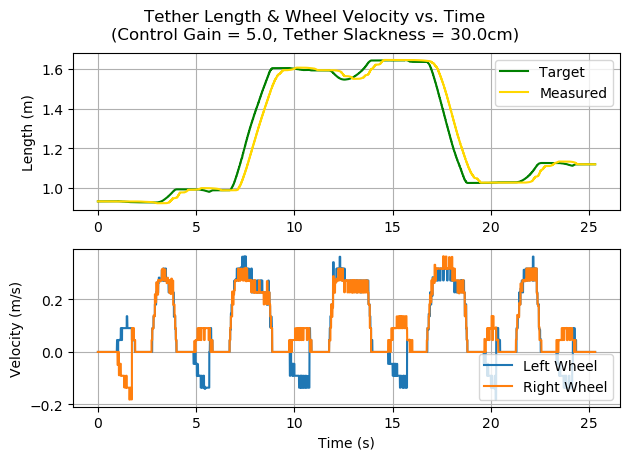

In [144]:
fig, axs = plt.subplots(2, 1)
fig.suptitle(f"Tether Length & Wheel Velocity vs. Time\n(Control Gain = {gain}, Tether Slackness = {slack * 100}cm)")

axs[0].plot(df["/target_tether_length"], color='green', label="Target")
axs[0].plot(df["/current_tether_length"], color='gold', label="Measured")
# axs[0].set_title("Tether Length & Wheel Velocity vs. Time")
axs[0].set_ylabel("Length (m)")
axs[0].legend()
axs[0].grid()

axs[1].plot(df["/enc_left_vel"], label="Left Wheel")
axs[1].plot(df["/enc_right_vel"], label="Right Wheel")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Velocity (m/s)")
axs[1].legend()
axs[1].grid()

# axs[1].set_title("Tether Error vs. Time")

fig.tight_layout(rect=[0, 0.03, 1, 0.92])

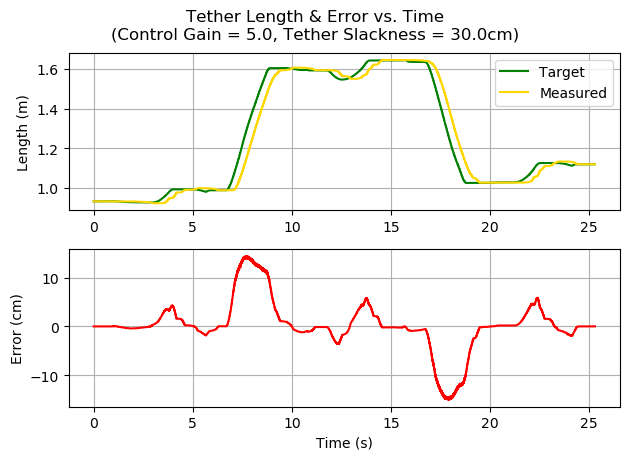

In [143]:
fig, axs = plt.subplots(2, 1)
fig.suptitle(f"Tether Length & Error vs. Time\n(Control Gain = {gain}, Tether Slackness = {slack * 100}cm)")

axs[0].plot(df["/target_tether_length"], color='green', label="Target")
axs[0].plot(df["/current_tether_length"], color='gold', label="Measured")
# axs[0].set_title("Tether Length & Tether Error vs. Time")
axs[0].set_ylabel("Length (m)")
axs[0].legend()
axs[0].grid()

axs[1].plot(df["tether_error"], 'r-')
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Error (cm)")
axs[1].grid()

# axs[1].set_title("Tether Error vs. Time")

fig.tight_layout(rect=[0, 0.03, 1, 0.92])